In [3]:
import re
import glob
import math
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


In [4]:
def list_traces_sorted(traces_path: str) -> List[Path]:
    """
    Return a list of trace files sorted by their numeric index in 'trace_<idx>.txt'.
    Accepts absolute or relative path.
    """
    paths = [Path(p) for p in glob.glob(str(Path(traces_path) / "trace_*.txt"))]
    if not paths:
        raise FileNotFoundError(f"No trace_*.txt files under: {traces_path}")
    # extract numeric index
    def idx(p: Path) -> int:
        m = re.match(r"trace_(\d+)\.txt$", p.name)
        if not m:
            raise ValueError(f"Bad trace filename: {p.name}")
        return int(m.group(1))
    paths.sort(key=idx)
    return paths

In [5]:
def load_inputs_matrix(inputs_file: str, ncols: int = 7) -> np.ndarray:
    """
    Load 'inputs.txt' as numeric matrix with ncols columns (default 7: V1..V7).
    Assumes space-separated values with no header.
    """
    df = pd.read_csv(inputs_file, sep=r"\s+", header=None, engine="python")
    if df.shape[1] != ncols:
        raise ValueError(f"Expected {ncols} columns, got {df.shape[1]} in {inputs_file}")
    return df.values  # (N, ncols)

In [6]:
def load_traces_matrix(traces_path: str) -> Tuple[np.ndarray, List[int]]:
    """
    Read all traces into a matrix of shape (N, S).
    Returns (traces, idx_list), where idx_list contains the numeric file indices (0-based).
    """
    files = list_traces_sorted(traces_path)
    idx_list = []
    rows = []
    for f in files:
        m = re.match(r"trace_(\d+)\.txt$", f.name)
        idx_list.append(int(m.group(1)))
        # robust read: allow whitespace/newlines; each file is 1D vector
        data = np.loadtxt(f, dtype=float)
        rows.append(np.atleast_1d(data))
    # sanity: ensure equal length (pad/raise if needed)
    lens = [r.size for r in rows]
    if len(set(lens)) != 1:
        raise ValueError(f"Traces have varying lengths: {set(lens)}")
    X = np.vstack(rows)  # (N, S)
    return X, idx_list

In [7]:
def align_inputs_to_traces(inputs: np.ndarray, idx_list: List[int]) -> np.ndarray:
    """
    Align inputs rows to trace files by 0-based index in filename.
    """
    max_idx = max(idx_list)
    if max_idx >= inputs.shape[0]:
        raise IndexError(
            f"inputs has only {inputs.shape[0]} rows, but file index {max_idx} appears."
        )
    aligned = inputs[np.array(idx_list), :]  # pick rows by 0-based indices
    return aligned


In [8]:
def window_traces(X: np.ndarray, qs: int, qe: Optional[int]) -> np.ndarray:
    """
    Slice columns [qs:qe] (1-based inclusive in your R; here we accept 1-based for familiarity).
    If qe is None, use full width. Returns a copy.
    """
    S = X.shape[1]
    if qe is None:
        qe = S
    # convert to 0-based python slicing
    qs0 = max(0, qs - 1)
    qe0 = min(S, qe)  # slice end is exclusive in Python, so keep as is
    if qs0 >= qe0:
        raise ValueError(f"Bad window [{qs}, {qe}] for S={S}")
    return X[:, qs0:qe0].copy()



In [9]:
def split_fixed_random(
    inputs_aligned: np.ndarray,
    v: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return (fixed_rows, random_rows) as arrays of row indices based on V1 == v criterion.
    """
    V1 = inputs_aligned[:, 0]
    fixed_rows = np.where(V1 == v)[0]
    random_rows = np.where(V1 != v)[0]
    if fixed_rows.size == 0 or random_rows.size == 0:
        raise ValueError("One of the groups is empty (fixed_rows or random_rows).")
    return fixed_rows, random_rows

In [10]:

def extract_groups(
    X: np.ndarray, fixed_rows: np.ndarray, random_rows: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build group matrices (fixed, random) by selecting corresponding rows.
    """
    fixed = X[fixed_rows, :]
    random = X[random_rows, :]
    return fixed, random


In [11]:

def tvla_welch_tcurve(fixed: np.ndarray, random: np.ndarray) -> np.ndarray:
    """
    Compute per-sample Welch's t-statistic (column-wise),
    using manual formula instead of scipy.
    Returns (S,) array of t-values.
    """
    if fixed.shape[1] != random.shape[1]:
        raise ValueError("fixed and random must have same number of columns")

    nx, S = fixed.shape
    ny, _ = random.shape

    # means per column
    mean_x = fixed.mean(axis=0)
    mean_y = random.mean(axis=0)

    # unbiased variances per column
    var_x = fixed.var(axis=0, ddof=1)
    var_y = random.var(axis=0, ddof=1)

    # Welch t formula
    denom = np.sqrt(var_x / nx + var_y / ny)
    # avoid division by zero
    denom[denom == 0] = np.nan

    tvals = (mean_x - mean_y) / denom
    return tvals


In [13]:
def plot_tvla_curve(
    tvals: np.ndarray,
    qs: int,
    qe: int,
    threshold: float = 4.5,
    title: str = "TVLA (Welch)",
    figsize: Tuple[float, float] = (10, 4),
    out_pdf: Optional[str] = None,
) -> None:
    x = np.arange(qs, qs + tvals.size)
    plt.figure(figsize=figsize)
    plt.plot(x, tvals, lw=1.3)
    plt.axhline(+threshold, color="r", ls="--")
    plt.axhline(-threshold, color="r", ls="--")
    plt.title(title)
    plt.xlabel(f"Sample index ({qs}-{qe})")
    plt.ylabel("t-value")
    plt.grid(True, alpha=0.3)
    if out_pdf:
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [23]:

def plot_power_curve_TVLA(
    m_values: np.ndarray,
    max_abs_t: np.ndarray,
    title: str = "TVLA max-|t| vs traces-per-group",
    figsize: Tuple[float, float] = (10, 4),
    out_pdf: Optional[str] = None,
) -> None:
    plt.figure(figsize=figsize)
    plt.bar(m_values, max_abs_t, width=max(1, int(len(m_values) / 40)))
    plt.title(title)
    plt.xlabel("Traces per group (m)")
    plt.ylabel("Max |t| across window")
    plt.grid(axis="y", alpha=0.3)
    if out_pdf:
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [25]:
def tvla_power_curve(
    fixed: np.ndarray,
    random: np.ndarray,
    min_fixed: int = 10,
    max_steps: int = 100,
    rng: Optional[np.random.Generator] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    For m from min_fixed..m_max (subsampled to <= max_steps points):
    - take the FIRST m traces from each group (as in your R code) and compute t-curve
      (deterministic), OR you can randomize selection if you want Monte Carlo flavour.
    - record max |t| in the window.
    Returns: (m_values, max_abs_t_values)
    """
    n_fixed, S = fixed.shape
    n_random, _ = random.shape
    m_max = min(n_fixed, n_random)
    if m_max < min_fixed:
        raise ValueError("Not enough traces per group for the power curve.")

    # choose up to max_steps evenly spaced m values (integers, unique)
    steps = min(max_steps, m_max - min_fixed + 1)
    m_vals = np.unique(np.round(np.linspace(min_fixed, m_max, steps)).astype(int))

    max_abs_t = np.empty_like(m_vals, dtype=float)
    for j, m in enumerate(m_vals):
        # deterministic prefix selection (to match your R approach):
        t_m = tvla_welch_tcurve(fixed[:m, :], random[:m, :])
        max_abs_t[j] = np.nanmax(np.abs(t_m))
    return m_vals, max_abs_t

In [27]:

def plot_power_curve_line_TVLA(m_vals: np.ndarray, max_abs_t: np.ndarray, title: str, out_pdf: str):
    """
    Line plot (not histogram): x = traces-per-group (m), y = max |t|.
    """
    plt.figure(figsize=(9, 4.8))
    plt.plot(m_vals, max_abs_t, marker="o", linewidth=1.8)
    plt.title(title)
    plt.xlabel("Number of traces per group (m)")
    plt.ylabel("Max |t| in window")
    plt.grid(True, which="both", linestyle=":", linewidth=0.7)
    plt.tight_layout()
    plt.savefig(out_pdf)
    plt.close()

In [29]:

def run_tvla_pipeline(
    name: str,
    traces_path: str,
    inputs_file: str,
    v: float = 0.5,
    qs: int = 1,
    qe: Optional[int] = None,
    tvla_threshold: float = 4.5,
    min_fixed: int = 10,
    out_dir: str = "./out_tvla",
    save_plots: bool = True,
) -> Dict[str, object]:
    """
    End-to-end TVLA pipeline:
      1) load traces+inputs, align by numeric index
      2) select window [qs:qe]
      3) split (V1 == v)
      4) compute Welch t-curve (manual implementation elsewhere)
      5) save plot/CSV (filenames include number of threshold exceedances)
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # 1) load / align
    X, idx_list = load_traces_matrix(traces_path)
    inputs = load_inputs_matrix(inputs_file, ncols=7)
    inputs_aligned = align_inputs_to_traces(inputs, idx_list)

    # 2) window
    Xw = window_traces(X, qs, qe)
    S = Xw.shape[1]
    if qe is None:  # for labeling
        qe = qs + S - 1

    # 3) split
    fixed_rows, random_rows = split_fixed_random(inputs_aligned, v)
    fixed, random = extract_groups(Xw, fixed_rows, random_rows)

    # 4) t-curve
    tvals = tvla_welch_tcurve(fixed, random)
    tvals_clean = np.where(np.isfinite(tvals), tvals, 0.0)

    # --- count exceedances before naming files ---
    exceed_idx_0based = np.where(np.abs(tvals) > tvla_threshold)[0]
    n_exceed = int(exceed_idx_0based.size)

    # 5) save CSV (filename includes count)
    t_csv = str(Path(out_dir) / f"tvalues_{name}_exceed{n_exceed}.csv")
    pd.DataFrame({"sample": np.arange(qs, qs + S), "t_value": tvals}).to_csv(t_csv, index=False)

    # 6) plot (filename includes count)
    t_pdf = str(Path(out_dir) / f"tvla_{name}_exceed{n_exceed}.pdf")
    if save_plots:
        plot_tvla_curve(
            tvals, qs, qe,
            threshold=tvla_threshold,
            title=f"TVLA — {name} (exceed={n_exceed})",
            out_pdf=t_pdf
        )

    # leakage points (1-based sample labeling for return)
    leaks_1based = exceed_idx_0based + qs

     # 5) POWER CURVE (line, not histogram)
    #m_vals, max_abs_t = tvla_power_curve(fixed, random, min_fixed=min_fixed, max_steps=100)
    #p_csv = str(Path(out_dir) / f"tvla_power_curve_{name}.csv")
    #pd.DataFrame({"traces_per_group": m_vals, "max_abs_t": max_abs_t}).to_csv(p_csv, index=False)

    #p_pdf = str(Path(out_dir) / f"tvla_power_curve_{name}.pdf")
    #if save_plots:
     #   plot_power_curve_line_TVLA(m_vals, max_abs_t,
      #                        title=f"TVLA power curve — {name}",
       #                       out_pdf=p_pdf)


    return dict(
        name=name,
        t_values=tvals,
        leakage_points=leaks_1based,
        fixed_count=fixed.shape[0],
        random_count=random.shape[0],
        window=(qs, qe),
        csv_tvalues=t_csv,
        pdf_tvalues=t_pdf if save_plots else None,
    )


In [49]:
res_tvla = run_tvla_pipeline(
    name="protected_1_neuron_jitters",
    traces_path="/Users/andrew/Desktop/thesis/only-traces/capture_traces/protected1stneuron_jitters_fixed_vs_fixed",
    inputs_file="/Users/andrew/Desktop/thesis/only-traces/capture_traces/protected1stneuron_jitters_fixed_vs_fixed/inputs.txt",
    v=2,
    qs=0,
    qe=24430,
    tvla_threshold=4.5,
    out_dir="/Users/andrew/Desktop/results_tvla/protected1stneuron_jitters_fixedvsfixed"
)
run_ksla_pipeline(
    name="protected_1_neuron_jitters_KSLA_0.1",
    traces_path="/Users/andrew/Desktop/thesis/only-traces/capture_traces/protected1stneuron_jitters_fixed_vs_fixed",
    inputs_file="/Users/andrew/Desktop/thesis/only-traces/capture_traces/protected1stneuron_jitters_fixed_vs_fixed/inputs.txt",
    v=2, qs=0, qe=24430,
    ksla_threshold=0.1,
    out_dir="/Users/andrew/Desktop/results_tvla/protected1stneuron_jitters_fixed_vs_fixed_KSLA",
    pc_qs=1, pc_qe=3000,    
    pc_win_size=20, pc_step=1
)

{'name': 'protected_1_neuron_jitters_KSLA_0.1',
 'ksla_threshold': 0.1,
 'D_values': array([0.043, 0.014, 0.049, ..., 0.045, 0.045, 0.032]),
 'exceed_idx': array([   49,    50,    51, ..., 16638, 16781, 19363]),
 'max_D': 0.39499999999999996,
 'max_D_at': 50,
 'csv_Dvalues': '/Users/andrew/Desktop/results_tvla/protected1stneuron_jitters_fixed_vs_fixed_KSLA/ksla_Dvalues_protected_1_neuron_jitters_KSLA_0.1_exceed1414.csv',
 'pdf_Dcurve': '/Users/andrew/Desktop/results_tvla/protected1stneuron_jitters_fixed_vs_fixed_KSLA/ksla_protected_1_neuron_jitters_KSLA_0.1_exceed1414.pdf',
 'power_curve_m': array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590, 

In [31]:
from pathlib import Path
from typing import Dict, Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- KSLA core ----------
def _ks_D_one(a: np.ndarray, b: np.ndarray) -> float:
    """
    Manual two-sample Kolmogorov–Smirnov D in [0,1].
    """
    a = np.asarray(a, dtype=float).ravel()
    b = np.asarray(b, dtype=float).ravel()
    if a.size == 0 or b.size == 0:
        return np.nan
    a_sorted = np.sort(a)
    b_sorted = np.sort(b)
    z = np.sort(np.concatenate([a_sorted, b_sorted]))
    Fa = np.searchsorted(a_sorted, z, side="right") / a_sorted.size
    Fb = np.searchsorted(b_sorted, z, side="right") / b_sorted.size
    return float(np.max(np.abs(Fa - Fb)))

def ksla_stat(fixed: np.ndarray, random: np.ndarray) -> np.ndarray:
    """
    Column-wise KS D statistics. Returns (S,) in [0,1] (NaN if empty group).
    """
    if fixed.shape[1] != random.shape[1]:
        raise ValueError("fixed and random must have same number of columns")
    S = fixed.shape[1]
    D = np.empty(S, dtype=float)
    for i in range(S):
        D[i] = _ks_D_one(fixed[:, i], random[:, i])
    # strong safety:
    D = np.clip(D, 0.0, 1.0)
    return D

# ---------- Plot helpers ----------
def plot_ksla_curve(
    Dvals: np.ndarray,
    qs: int,
    qe: int,
    threshold: float = 0.2,
    title: str = "KSLA (K-S D)",
    figsize=(10, 4.2),
    out_pdf: Optional[str] = None,
) -> None:
    x = np.arange(qs, qs + Dvals.size)
    y = np.where(np.isfinite(Dvals), Dvals, 0.0)
    plt.figure(figsize=figsize)
    plt.plot(x, y, lw=1.4)
    plt.axhline(threshold, color="r", ls="--")
    plt.title(title)
    plt.xlabel(f"Sample index ({qs}-{qe})")
    plt.ylabel("KS D")
    plt.grid(True, ls=":", alpha=0.6)
    if out_pdf:
        plt.tight_layout()
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def plot_power_curve_line_KSLA(m_vals: np.ndarray, y_vals: np.ndarray, title: str, out_pdf: str):
    plt.figure(figsize=(9, 4.8))
    plt.plot(m_vals, y_vals, marker="o", lw=1.8)
    plt.title(title)
    plt.xlabel("Number of traces per group (m)")
    plt.ylabel("Max KS D in window")
    plt.grid(True, ls=":", alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close()

# ---------- KSLA power curve ----------
def ksla_power_curve(
    fixed: np.ndarray,
    random: np.ndarray,
    min_fixed: int = 10,
    max_steps: int = 100,
    col_slice: Optional[slice] = None,  # fixed subwindow of columns
    win_size: Optional[int] = None,     # sliding window length (over columns)
    win_step: int = 256,                # sliding step
) -> Tuple[np.ndarray, np.ndarray]:
    """
    For m in [min_fixed..m_max] (subsampled to <= max_steps points):
      - take first m traces from each group,
      - compute column-wise KS D,
      - record the maximum D either:
          * inside col_slice, or
          * over all sliding windows of length win_size (step=win_step), or
          * over the full range if both are None.
    Returns: (m_values, max_D_values)
    """
    n_fixed, S = fixed.shape
    n_random, _ = random.shape
    m_max = min(n_fixed, n_random)
    if m_max < min_fixed:
        raise ValueError("Not enough traces per group for the power curve.")
    steps = min(max_steps, m_max - min_fixed + 1)
    m_vals = np.unique(np.round(np.linspace(min_fixed, m_max, steps)).astype(int))

    def max_in_cols(D_curve: np.ndarray) -> float:
        if col_slice is not None:
            return float(np.nanmax(D_curve[col_slice]))
        if win_size is not None:
            if win_size > S:
                raise ValueError("win_size exceeds number of samples")
            best = 0.0
            for start in range(0, S - win_size + 1, max(1, win_step)):
                end = start + win_size
                v = float(np.nanmax(D_curve[start:end]))
                if v > best:
                    best = v
            return best
        return float(np.nanmax(D_curve))

    max_D = np.empty_like(m_vals, dtype=float)
    for j, m in enumerate(m_vals):
        D_m = ksla_stat(fixed[:m, :], random[:m, :])
        max_D[j] = max_in_cols(D_m)
    return m_vals, max_D

# ---------- End-to-end KSLA pipeline ----------
def run_ksla_pipeline(
    name: str,
    traces_path: str,
    inputs_file: str,
    v: float = 0.5,
    qs: int = 1,
    qe: Optional[int] = None,
    ksla_threshold: float = 0.2,
    min_fixed: int = 10,
    out_dir: str = "./out_ksla",
    save_plots: bool = True,
    # power-curve windowing:
    pc_qs: Optional[int] = None,       # absolute sample indices (subset for power curve)
    pc_qe: Optional[int] = None,
    pc_win_size: Optional[int] = None, # sliding window length over chosen subset
    pc_step: int = 256,
) -> Dict[str, object]:
    """
    1) load traces+inputs and align (uses your existing helpers)
    2) window [qs:qe]
    3) split fixed/random (V1 == v)
    4) compute KSLA curve, save CSV/PDF (filenames include exceed count)
    5) compute KSLA power curve (max D vs m) with optional subwindow/sliding window, save CSV/PDF
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # --- your loaders/splitters (assumed available) ---
    X, idx_list = load_traces_matrix(traces_path)
    inputs = load_inputs_matrix(inputs_file, ncols=7)
    inputs_aligned = align_inputs_to_traces(inputs, idx_list)

    # window
    Xw = window_traces(X, qs, qe)
    S = Xw.shape[1]
    if qe is None:
        qe = qs + S - 1

    # split & extract groups
    fixed_rows, random_rows = split_fixed_random(inputs_aligned, v)
    fixed, random = extract_groups(Xw, fixed_rows, random_rows)  # shapes: (Nf, S), (Nr, S)

    # ---- KSLA curve ----
    Dvals = ksla_stat(fixed, random)
    exceed_idx_0b = np.where(Dvals > ksla_threshold)[0]
    n_exceed = int(exceed_idx_0b.size)

    # CSV
    D_csv = str(Path(out_dir) / f"ksla_Dvalues_{name}_exceed{n_exceed}.csv")
    pd.DataFrame({"sample": np.arange(qs, qs + S), "D": Dvals}).to_csv(D_csv, index=False)

    # PDF
    D_pdf = str(Path(out_dir) / f"ksla_{name}_exceed{n_exceed}.pdf")
    if save_plots:
        plot_ksla_curve(Dvals, qs, qe, threshold=ksla_threshold,
                        title=f"KSLA — {name} (exceed={n_exceed})",
                        out_pdf=D_pdf)

    # ---- KSLA power curve ----
    # allow subrange [pc_qs:pc_qe] AND sliding window inside it
    subF, subR = fixed, random
    sub_qs, sub_qe = qs, qe
    if pc_qs is not None or pc_qe is not None:
        a = pc_qs if pc_qs is not None else qs
        b = pc_qe if pc_qe is not None else qe
        a = max(a, qs); b = min(b, qe)
        if a > b:
            raise ValueError("power-curve window is empty")
        start = a - qs
        end = b - qs + 1
        subF = fixed[:, start:end]
        subR = random[:, start:end]
        sub_qs, sub_qe = a, b

    m_vals, max_D = ksla_power_curve(
        subF, subR,
        min_fixed=min_fixed, max_steps=100,
        col_slice=None,               # we already cut subrange above
        win_size=pc_win_size, win_step=pc_step
    )

    # CSV for power curve
    p_csv = str(Path(out_dir) / f"ksla_power_curve_{name}.csv")
    pd.DataFrame({"traces_per_group": m_vals, "max_D": max_D}).to_csv(p_csv, index=False)

    # PDF for power curve (line)
    subtitle = f" window={sub_qs}-{sub_qe}"
    if pc_win_size is not None:
        subtitle += f", sliding L={pc_win_size}, step={pc_step}"
    p_pdf = str(Path(out_dir) / f"ksla_power_curve_{name}.pdf")
    if save_plots:
        plot_power_curve_line_KSLA(m_vals, max_D, f"KSLA power curve — {name}{subtitle}", p_pdf)

    # return summary (optional)
    return dict(
        name=name,
        ksla_threshold=ksla_threshold,
        D_values=Dvals,
        exceed_idx=(exceed_idx_0b + qs),
        max_D=float(np.nanmax(Dvals)),
        max_D_at=int(np.nanargmax(Dvals) + qs),
        csv_Dvalues=D_csv,
        pdf_Dcurve=D_pdf if save_plots else None,
        power_curve_m=m_vals,
        power_curve_max_D=max_D,
        csv_power=p_csv,
        pdf_power=p_pdf if save_plots else None,
        power_window=dict(range=(sub_qs, sub_qe),
                          sliding=None if pc_win_size is None else dict(L=pc_win_size, step=pc_step)),
        counts=dict(fixed=fixed.shape[0], random=random.shape[0], samples=S),
        main_window=(qs, qe),
    )


In [33]:
def _yuen_g(n: int, gamma: float) -> int:
    if not (0 <= gamma < 0.5):
        raise ValueError("gamma must be in [0, 0.5)")
    return int(np.floor(gamma * n))

def _trim_vec(x: np.ndarray, g: int) -> np.ndarray:
    xs = np.sort(np.asarray(x, dtype=float))
    if g <= 0:
        return xs
    if 2*g >= xs.size:
        raise ValueError("Too much trimming for given sample size.")
    return xs[g: xs.size - g]

def _winsorize_vec(x: np.ndarray, g: int) -> np.ndarray:
    xs = np.sort(np.asarray(x, dtype=float))
    n = xs.size
    if g <= 0:
        return xs
    if 2*g >= n:
        raise ValueError("Too much winsorization for given sample size.")
    lower = xs[g]
    upper = xs[n - g - 1]
    xs[:g] = lower
    xs[n - g:] = upper
    return xs

def _trimmed_mean(x: np.ndarray, gamma: float = 0.2) -> float:
    g = _yuen_g(x.size, gamma)
    return float(np.mean(_trim_vec(x, g)))

def _winsorized_var(x: np.ndarray, gamma: float = 0.2) -> float:
    g = _yuen_g(x.size, gamma)
    wx = _winsorize_vec(x, g)
    return float(np.var(wx, ddof=1))  # unbiased sample variance

def yuen_t_two_sample(x: np.ndarray, y: np.ndarray, gamma: float = 0.2):
    """Двовибірковий t Юена для однієї колонки."""
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    n1, n2 = x.size, y.size
    g1, g2 = _yuen_g(n1, gamma), _yuen_g(n2, gamma)
    h1, h2 = n1 - 2*g1, n2 - 2*g2
    if h1 < 2 or h2 < 2:
        raise ValueError("Too much trimming for given sample sizes.")

    x_tmean = _trimmed_mean(x, gamma)
    y_tmean = _trimmed_mean(y, gamma)
    s2w1 = _winsorized_var(x, gamma)
    s2w2 = _winsorized_var(y, gamma)

    q1 = ((n1 - 1) * s2w1) / (h1 * (h1 - 1))
    q2 = ((n2 - 1) * s2w2) / (h2 * (h2 - 1))
    se2 = q1 + q2
    tval = (x_tmean - y_tmean) / np.sqrt(se2)

    # df Юена (Welch–Satterthwaite):
    df = (se2**2) / ((q1**2) / (h1 - 1) + (q2**2) / (h2 - 1))
    return float(tval), float(df)

def yuen_tcurve(fixed: np.ndarray, random: np.ndarray, gamma: float = 0.2) -> np.ndarray:
    """t-значення Юена по всіх семплах (колонках)."""
    fixed = np.asarray(fixed, dtype=float)
    random = np.asarray(random, dtype=float)
    if fixed.shape[1] != random.shape[1]:
        raise ValueError("fixed and random must have the same number of columns.")
    T = fixed.shape[1]
    tvals = np.empty(T, dtype=float)
    for j in range(T):
        tvals[j], _ = yuen_t_two_sample(fixed[:, j], random[:, j], gamma=gamma)
    return tvals

# ===== Плоттер у стилі TVLA-кривої (без power curve) =============================
def plot_yuen_curve(
    tvals: np.ndarray,
    qs: int,
    qe: int,
    threshold: float,
    title: str,
    out_pdf: Optional[str] = None,
):
    S = tvals.size
    x = np.arange(qs, qs + S)  # 1-based підпис семплів, як у твоєму TVLA
    plt.figure()
    plt.plot(x, tvals, linewidth=1.2)
    plt.axhline(0.0, linestyle="--", linewidth=0.8)
    plt.axhline(+threshold, linestyle=":", linewidth=0.8)
    plt.axhline(-threshold, linestyle=":", linewidth=0.8)
    plt.xlabel("Sample")
    plt.ylabel("t-value (Yuen, trimmed mean)")
    plt.title(title)
    plt.tight_layout()
    if out_pdf:
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.close()

# ===== End-to-end пайплайн як у тебе =============================================
def run_yuen_pipeline(
    name: str,
    traces_path: str,
    inputs_file: str,
    v: float = 0.5,
    qs: int = 1,
    qe: Optional[int] = None,
    yuen_threshold: float = 4.5,
    gamma: float = 0.2,
    out_dir: str = "./out_yuen",
    save_plots: bool = True,
) -> Dict[str, object]:
    """
    End-to-end Yuen pipeline (аналогічно твоєму TVLA-пайплайну, без power curve):
      1) load traces+inputs, align by numeric index
      2) select window [qs:qe] (1-based labeling)
      3) split (V1 == v)
      4) compute Yuen trimmed-mean t-curve (NumPy-only)
      5) save plot/CSV (імена включають кількість перевищень порога)
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # 1) load / align
    X, idx_list = load_traces_matrix(traces_path)
    inputs = load_inputs_matrix(inputs_file, ncols=7)
    inputs_aligned = align_inputs_to_traces(inputs, idx_list)  # твоя функція

    # 2) window
    Xw = window_traces(X, qs, qe)  # твоя функція: 1-based -> всередині конвертує
    S = Xw.shape[1]
    if qe is None:  # для підписів
        qe = qs + S - 1

    # 3) split
    fixed_rows, random_rows = split_fixed_random(inputs_aligned, v)  # твоя функція
    fixed, random = extract_groups(Xw, fixed_rows, random_rows)      # твоя функція

    # 4) Yuen t-curve
    tvals = yuen_tcurve(fixed, random, gamma=gamma)
    tvals_clean = np.where(np.isfinite(tvals), tvals, 0.0)

    # --- count exceedances before naming files ---
    exceed_idx_0based = np.where(np.abs(tvals_clean) > yuen_threshold)[0]
    n_exceed = int(exceed_idx_0based.size)

    # 5) save CSV (filename includes count)
    t_csv = str(Path(out_dir) / f"yuen_tvalues_{name}_exceed{n_exceed}.csv")
    pd.DataFrame({"sample": np.arange(qs, qs + S), "t_value": tvals}).to_csv(t_csv, index=False)

    # 6) plot PDF (filename includes count)
    t_pdf = str(Path(out_dir) / f"yuen_{name}_exceed{n_exceed}.pdf")
    if save_plots:
        plot_yuen_curve(
            tvals_clean, qs, qe,
            threshold=yuen_threshold,
            title=f"Yuen (trim={gamma}) — {name} (exceed={n_exceed})",
            out_pdf=t_pdf
        )

    # leakage points (1-based sample labeling for return)
    leaks_1based = exceed_idx_0based + qs

    return dict(
        name=name,
        t_values=tvals,
        leakage_points=leaks_1based,
        fixed_count=fixed.shape[0],
        random_count=random.shape[0],
        window=(qs, qe),
        csv_tvalues=t_csv,
        pdf_tvalues=t_pdf if save_plots else None,
        gamma=gamma,
        threshold=yuen_threshold,
    )

In [75]:
res = run_yuen_pipeline(
    name= "yuen unprotected1neuron",
    traces_path="/Users/andrew/Desktop/thesis/only-traces/capture_traces/unprotected1neuron",
    inputs_file="/Users/andrew/Desktop/thesis/only-traces/capture_traces/unprotected1neuron/inputs.txt",
    qs=1, qe=24430,
    v=0.5,
    gamma=0.2,
    yuen_threshold=4.5,
    out_dir="/Users/andrew/Desktop/results_tvla/yuen_1stneuron_unprot"
)


In [35]:
import os
from pathlib import Path

# Шлях до вхідної папки
base_dir = "/Users/andrew/Desktop/thesis/only-traces/capture_traces"
# Куди зберігати результати
out_root = "/Users/andrew/Desktop/results_ksla"

# Проходимо всі підпапки
for folder_name in sorted(os.listdir(base_dir)):
    if folder_name.endswith("_data"):
        continue  # ігноруємо *_data

    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Створюємо унікальну папку для результатів
    out_dir = os.path.join(out_root, f"ksla_{folder_name}")
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    traces_path = os.path.join(folder_path)
    inputs_file = os.path.join(folder_path, "inputs.txt")

    if not (os.path.exists(traces_path) and os.path.exists(inputs_file)):
        print(f"❌ skipped {folder_name} — no traces/inputs")
        continue

    print(f"✅ Аналізую: {folder_name}")
    run_ksla_pipeline(
        name=folder_name,
        traces_path=traces_path,
        inputs_file=inputs_file,
        out_dir=out_dir,
        save_plots=True,
        pc_qs=1000,
        pc_qe=4000,
        pc_win_size=512,
        pc_step=256
    )

❌ Пропущено .ipynb_checkpoints — немає traces/inputs
❌ Пропущено network — немає traces/inputs
✅ Аналізую: protected1neuron
✅ Аналізую: protected1stneuron_jitters
✅ Аналізую: protected2neuron
✅ Аналізую: protected3neuron
✅ Аналізую: protected4neuron
✅ Аналізую: protected5neuron
✅ Аналізую: protected6neuron
✅ Аналізую: protected7neuron
✅ Аналізую: unprotected1neuron
✅ Аналізую: unprotected2neuron
✅ Аналізую: unprotected3neuron
✅ Аналізую: unprotected4neuron
✅ Аналізую: unprotected5neuron
✅ Аналізую: unprotected6neuron
✅ Аналізую: unprotected7neuron


In [35]:
import os
from pathlib import Path

# Шлях до вхідної папки
base_dir = "/Users/andrew/Desktop/thesis/only-traces/capture_traces"
# Куди зберігати результати
out_root = "/Users/andrew/Desktop/results_ksla0.1"

# Проходимо всі підпапки
for folder_name in sorted(os.listdir(base_dir)):
    if folder_name.endswith("_data"):
        continue  # ігноруємо *_data

    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Створюємо унікальну папку для результатів
    out_dir = os.path.join(out_root, f"ksla_{folder_name}")
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    traces_path = os.path.join(folder_path)
    inputs_file = os.path.join(folder_path, "inputs.txt")

    if not (os.path.exists(traces_path) and os.path.exists(inputs_file)):
        print(f"❌ skipped {folder_name} — no traces/inputs")
        continue

    print(f"✅ analyze: {folder_name}")
    run_ksla_pipeline(
        name=folder_name,
        traces_path=traces_path,
        inputs_file=inputs_file,
        out_dir=out_dir,
        save_plots=True,
        pc_qs=1000,
        pc_qe=4000,
        pc_win_size=512,
        pc_step=256,
        ksla_threshold=0.1
    )

❌ skipped .ipynb_checkpoints — no traces/inputs
❌ skipped network — no traces/inputs
✅ analyze: protected1neuron
✅ analyze: protected1stneuron_jitters
✅ analyze: protected2neuron
✅ analyze: protected3neuron
✅ analyze: protected4neuron
✅ analyze: protected5neuron
✅ analyze: protected6neuron
✅ analyze: protected7neuron
✅ analyze: unprotected1neuron
✅ analyze: unprotected2neuron
✅ analyze: unprotected3neuron
✅ analyze: unprotected4neuron
✅ analyze: unprotected5neuron
✅ analyze: unprotected6neuron
✅ analyze: unprotected7neuron


In [38]:
import os
from pathlib import Path

# імпорт твоєї функції
# де лежать підпапки типу protected1neuron, unprotected3neuron, ...
base_dir = "/Users/andrew/Desktop/thesis/only-traces/capture_traces"

# куди складати результати YTLA
out_root = "/Users/andrew/Desktop/results_ytla"

Path(out_root).mkdir(parents=True, exist_ok=True)

for folder_name in sorted(os.listdir(base_dir)):
    # пропускаємо все, що закінчується на "_data"
    if folder_name.endswith("_data"):
        continue

    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # очікувані файли всередині папки нейрона
    traces_path = os.path.join(folder_path)
    inputs_file = os.path.join(folder_path, "inputs.txt")

    if not (os.path.exists(traces_path) and os.path.exists(inputs_file)):
        print(f"❌ Skip {folder_name} — no traces.txt or inputs.txt")
        continue

    out_dir = os.path.join(out_root, f"yuen_{folder_name}")
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    print(f"✅ YTLA для: {folder_name}")
    run_yuen_pipeline(
        name=folder_name,
        traces_path=traces_path,
        inputs_file=inputs_file,
        v=0.5,                 # як у KSLA/TVLA
        qs=1,
        qe=None,               # увесь діапазон; можеш задати інтервал, якщо треба
        yuen_threshold=4.5,    # класичний TVLA-поріг
        gamma=0.2,             # 20% trimming
        out_dir=out_dir,
        save_plots=True
    )


❌ Skip .ipynb_checkpoints — no traces.txt or inputs.txt
❌ Skip network — no traces.txt or inputs.txt
✅ YTLA для: protected1neuron
✅ YTLA для: protected1stneuron_jitters
✅ YTLA для: protected2neuron
✅ YTLA для: protected3neuron
✅ YTLA для: protected4neuron
✅ YTLA для: protected5neuron
✅ YTLA для: protected6neuron
✅ YTLA для: protected7neuron
✅ YTLA для: unprotected1neuron
✅ YTLA для: unprotected2neuron
✅ YTLA для: unprotected3neuron
✅ YTLA для: unprotected4neuron
✅ YTLA для: unprotected5neuron
✅ YTLA для: unprotected6neuron
✅ YTLA для: unprotected7neuron


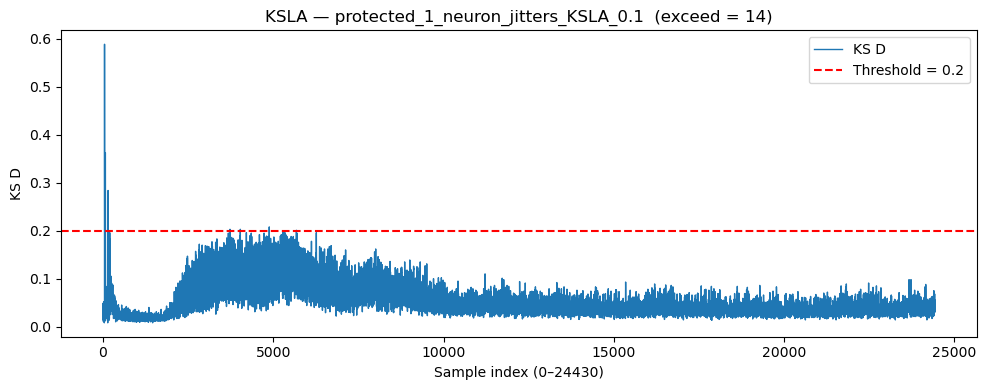

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Завантаження CSV (колонка 'D' має містити KS-значення)
data = pd.read_csv("/Users/andrew/Desktop/results_tvla/protected1stneuron_jitters_fixed_vs_fixed_KSLA/ksla_Dvalues_protected_1_neuron_jitters_KSLA_0.1_exceed3067.csv")  # заміни шлях, якщо потрібно
d_vals = data["D"].values
threshold = 0.2

# Рахуємо кількість перевищень порогу
exceed_count = np.sum(d_vals > threshold)

plt.figure(figsize=(10, 4))
plt.plot(d_vals, label="KS D", linewidth=1)
plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.xlabel("Sample index (0–24430)")
plt.ylabel("KS D")
plt.title(f"KSLA — protected_1_neuron_jitters_KSLA_0.1  (exceed = {exceed_count})")
plt.legend()
plt.tight_layout()
plt.show()
